<h1 style="
font-family: Roboto;
font-size: 3em;
text-align: center;
color: white;
background:#a106f4;
padding: 20px;
margin: 10px;
border-radius: 20px;
text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);
">
Twitter Sentiment Analysis
</h1>

<center>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*sDa7Oqnh-zRXPPewKZid4g.png" alt="X Logo" style="max-width: 60%; border-radius:40px; background:white">
</center>

# <p style="font-family: Roboto;font-size: 2.5rem;text-align: center;color: white;background:#b84fce;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Importing Libraries</p>

In [1]:
import re
import nltk
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

# <p style="font-family: Roboto;font-size: 2.5rem;text-align: center;color: white;background:#b84fce;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Loading & Exploring Dataset</p>


In [2]:
# Loading Dataset
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", header=None)
df.columns = ["sentiment", "id", "date", "flag", "user", "text"]
df['sentiment'] = df['sentiment'].map({0:"Negative", 4:"Positive"})
df.head()

,sentiment,id,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Selcting Important Features
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [4]:
# shape
df.shape

(1600000, 2)

In [5]:
# information
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1600000 entries, 0 to 1599999

Data columns (total 2 columns):

 #   Column     Non-Null Count    Dtype 

---  ------     --------------    ----- 

 0   sentiment  1600000 non-null  object

 1   text       1600000 non-null  object

dtypes: object(2)

memory usage: 24.4+ MB


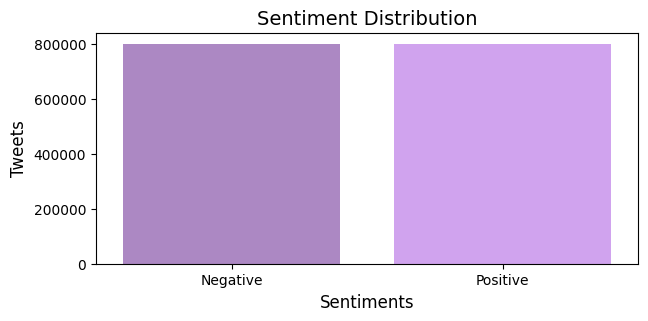

In [6]:
# Positive & Negative Data
plt.figure(figsize=(7,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])
plt.xlabel("Sentiments", size=12)
plt.ylabel('Tweets', size=12)
plt.title("Sentiment Distribution", size=14)
plt.show()

# <p style="font-family: Roboto; font-size: 2.5rem;text-align: center;color: white;background:#b84fce;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Text Preprocessing</p>

In [7]:
# Random Text Sample Analysis
random_index = [random.randint(0, df.shape[0]) for i in range(10)]
for i in df['text'].loc[random_index]:
    print(i)

is about to go to work 

The library should have a no last calls policy!! 

Late night in the ATL! Walkin' in Piedmont tomorrow afternoon. First day of workin' out since that &quot;flu&quot; episode! Wish the doc well!  

Uhoh... puppy has sick belly. 

Forgot to twitter my sushi 

Idk. But I should stop while I'm ahead. 

eattin sunflower seeds mm 

Home from work. Tired but in that good way.  hope everyones saturday was good.

Eyelash in my eye 

F spontaneity. hello pillow 


`Note`: Here we can see the textual data contains
    
1. links
2. mentions (@)
3. other special characters



## <p style="font-family: Roboto;font-size: 2rem;text-align: center;color: white;background:#a67be0;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Data Cleaning</p>

In [8]:
# All Patterns
mention_pattern = r'@\S+|#\S+'  # Pattern to match mentions (words starting with @ and #)
url_pattern = r"https?:(?:www\.)?\S+"  # Pattern to match URLs (starting with http or https)
non_alphanumeric_pattern = r"[^A-Za-z0-9\s]+"  # Pattern to match non-alphanumeric characters (including punctuation)

In [9]:
# Data Cleaning Function 
def data_cleaning(text):
    # Lowercasing 
    lower_text = str.lower(text)
    
    # Removing all unnecessary data 
    clean_text = re.sub(mention_pattern + '|' + url_pattern + '|' + non_alphanumeric_pattern, ' ', lower_text)
    
    return clean_text

In [10]:
# Performing Data Cleaning
df['text'] = df['text'].apply(data_cleaning)

## <p style="font-family: Roboto;font-size: 2rem;text-align: center;color: white;background:#a67be0;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Tokenization</p>

In [11]:
from tqdm import tqdm
tqdm.pandas()

# Apply word_tokenize with a progress bar
df['tokenized text'] = df['text'].progress_apply(lambda document: word_tokenize(document.strip()))

100%|██████████| 1600000/1600000 [05:38<00:00, 4720.83it/s]


## <p style="font-family: Roboto;font-size: 2rem;text-align: center;color: white;background:#a67be0;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Stopwords Removal</p>

In [12]:
nltk.download('stopwords')

# Getting list of stopwords
stop_words = set(stopwords.words('english'))

# Removing all Stopwords
df['clean_tokens'] = df['tokenized text'].progress_apply(lambda tokens: [token for token in tokens if token not in stop_words])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 1600000/1600000 [00:11<00:00, 134755.80it/s]


## <p style="font-family: Roboto;font-size: 2rem;text-align: center;color: white;background:#a67be0;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Lemmatization</p>

In [13]:
# To Avoid Error that might occur, if we try running lematization
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip

   creating: /usr/share/nltk_data/corpora/wordnet/

  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  

  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  

  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  

  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  

  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  

  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  

  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  

  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  

  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  

  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  

  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  

  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  

  inflating: /usr/share/nltk_data/corpora/wordnet/README  

  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  

  inflating: /usr

In [14]:
# Appling Lemmatization on Clean Tokens
lemmatizer = WordNetLemmatizer()

# Applying Lemmatization
df['lemmatized text'] = df['clean_tokens'].progress_apply(lambda tokens: ' '.join([lemmatizer.lemmatize(token, pos='v') for token in tokens]))

100%|██████████| 1600000/1600000 [01:32<00:00, 17248.86it/s]


# <p style="font-family: Roboto;font-size: 2.5rem;text-align: center;color: white;background:#b84fce;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Word Cloud For Positive & Negative Sentiments</p>

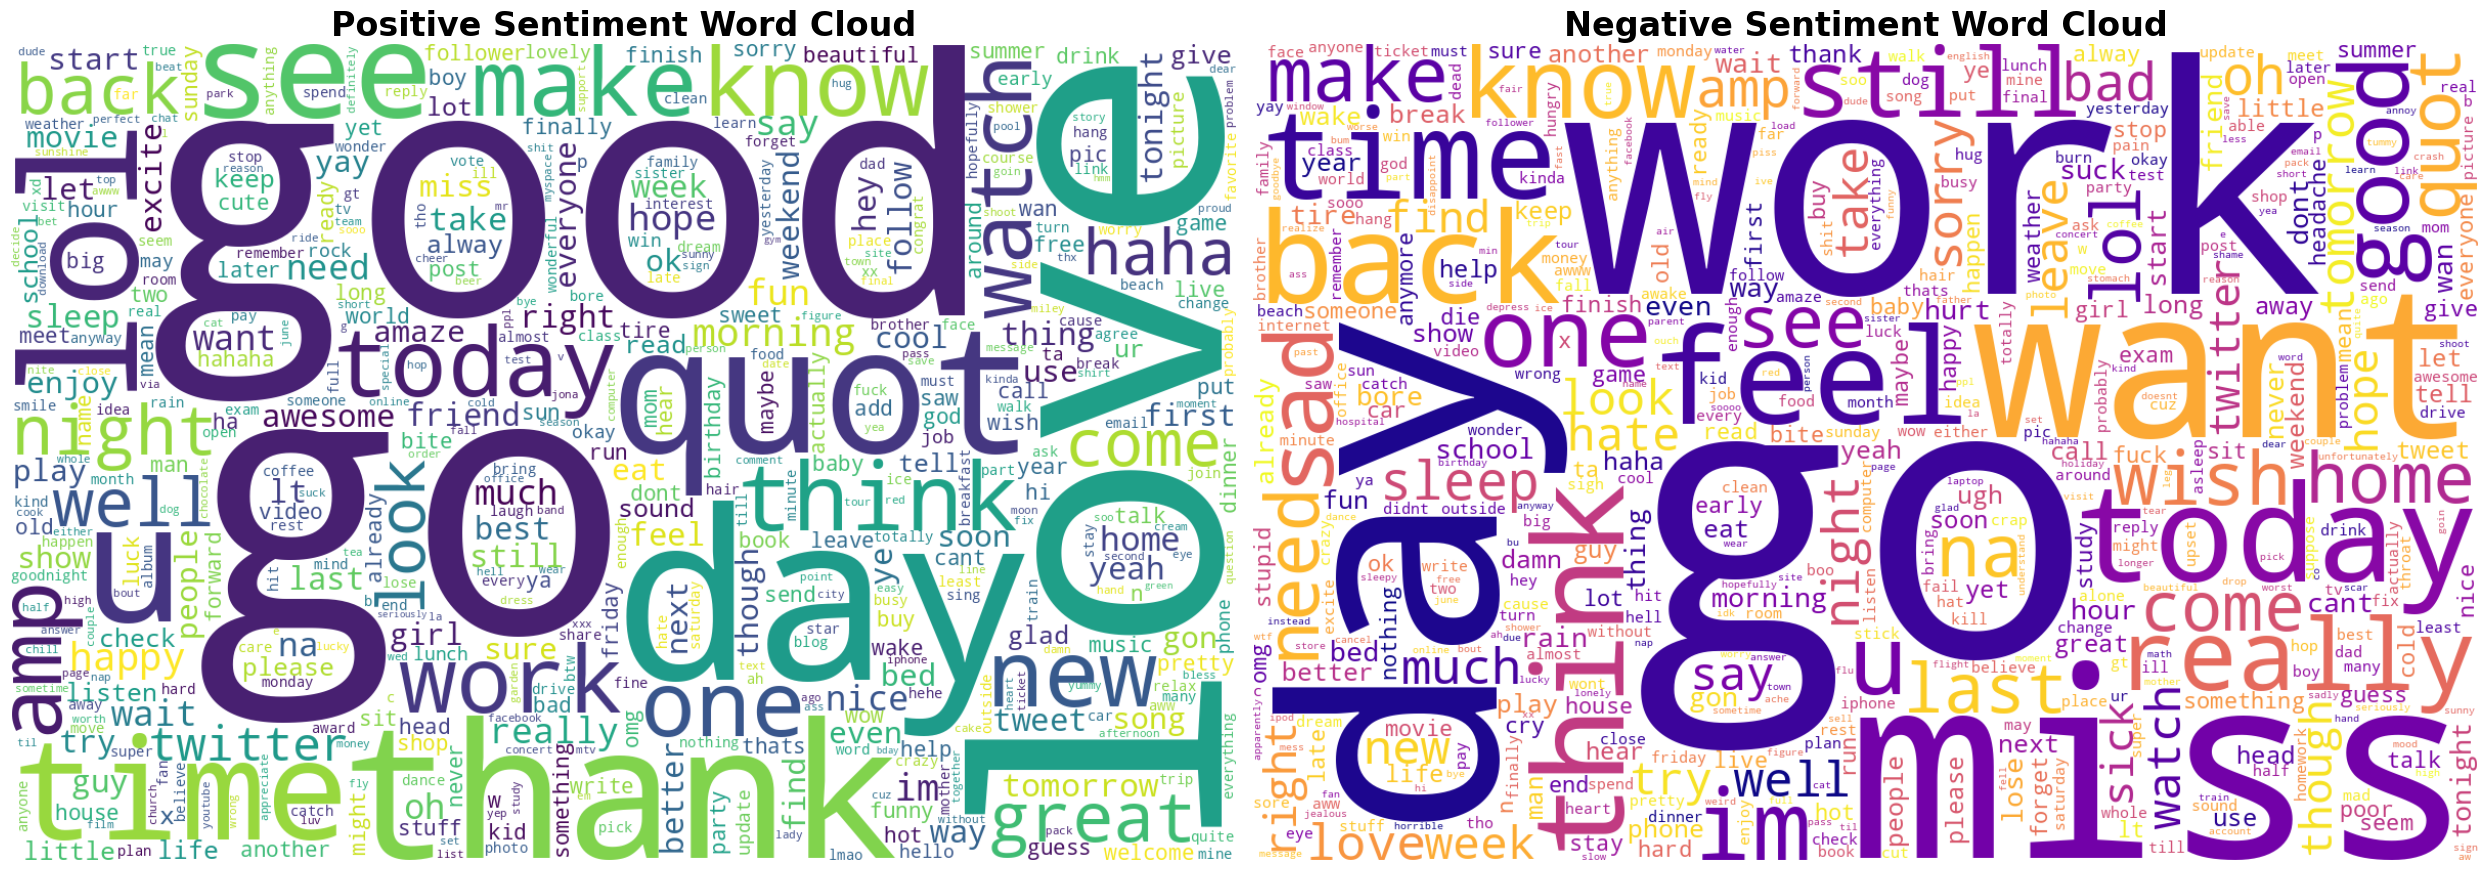

In [15]:
# Filter out positive and negative sentiment data
positive = df[df['sentiment'] == 'Positive']['lemmatized text']
negative = df[df['sentiment'] == 'Negative']['lemmatized text']

# Combine text data into single strings
positive_data = " ".join(positive)
negative_data = " ".join(negative)

# Create WordCloud objects
wc_positive = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='viridis',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(positive_data)

wc_negative = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='plasma',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(negative_data)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Plot positive sentiment word cloud
axes[0].imshow(wc_positive, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Positive Sentiment Word Cloud", fontsize=24, fontweight='bold')

# Plot negative sentiment word cloud
axes[1].imshow(wc_negative, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Negative Sentiment Word Cloud", fontsize=24, fontweight='bold')

plt.tight_layout()
plt.show()

# <p style="font-family: Roboto;font-size: 2.5rem;text-align: center;color: white;background:#b84fce;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Outlier Detection & Removal</p>

In [16]:
# Creating new features
df['no_of_charcters'] = df['lemmatized text'].progress_apply(len)
df['no_of_words'] = df['lemmatized text'].progress_apply(lambda document: word_tokenize(document)).apply(len)

100%|██████████| 1600000/1600000 [00:03<00:00, 476770.99it/s]

100%|██████████| 1600000/1600000 [04:29<00:00, 5928.29it/s]


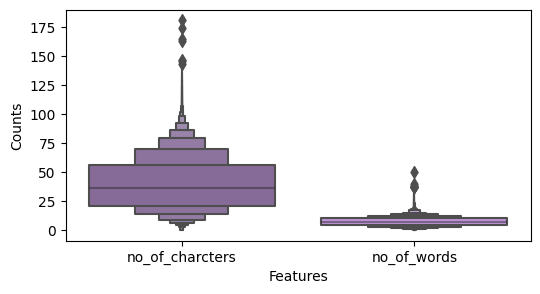

In [17]:
# Plotting Boxplot
plt.figure(figsize=(6,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.boxenplot(df[['no_of_charcters', 'no_of_words']], palette=[colors[5], colors[8]])
plt.xlabel("Features")
plt.ylabel("Counts")
plt.show()

In [18]:
# Removing Outliers
df = df[(df['no_of_charcters']<100) & (df['no_of_words']<20)]

# <p style="font-family: Roboto;font-size: 2.5rem;text-align: center;color: white;background:#b84fce;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Text Representation</p>

In [19]:
# splitting the dataset
X = df['lemmatized text']
y = df['sentiment'].map({"Negative":0, "Positive":1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [20]:
# Applying Vectorization Techniques
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(tqdm(X_train, desc="Vectorizing Text"))

Vectorizing Text: 100%|██████████| 1191448/1191448 [00:32<00:00, 36368.48it/s]


TfidfVectorizer(ngram_range=(1, 2))

In [21]:
X_train = vectorizer.transform(tqdm(X_train))
X_test = vectorizer.transform(tqdm(X_test))

100%|██████████| 1191448/1191448 [00:32<00:00, 36276.73it/s]

100%|██████████| 397150/397150 [00:10<00:00, 36505.92it/s]


# <p style="font-family: Roboto;font-size: 2.5rem;text-align: center;color: white;background:#b84fce;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Model Training</p>

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB()
}

model_performance = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred, average='weighted')
    precision = precision_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    model_performance[model_name] = {
        "Training Accuracy": training_accuracy,
        "Testing Accuracy": testing_accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1
    }
    
    print(f"Model: {model_name}")
    print(f"Training Accuracy: {training_accuracy}")
    print(f"Testing Acciracy: {testing_accuracy}")
    print("--"*20)

Model: Logistic Regression

Training Accuracy: 0.8543528546776695

Testing Acciracy: 0.7886692685383356

----------------------------------------

Model: Naive Bayes

Training Accuracy: 0.8922982790688305

Testing Acciracy: 0.7724814301901045

----------------------------------------


# <p style="font-family: Roboto;font-size: 2.5rem;text-align: center;color: white;background:#b84fce;padding: 20px;margin: 10px;border-radius: 50px;text-shadow: 5px 5px 8px rgba(0, 0, 0, 0.8);">Model Evaluation</p>

In [23]:
# Convert model performance dictionary to DataFrame
df_performance = pd.DataFrame(model_performance).T
df_performance.reset_index(inplace=True)
df_performance.rename(columns={'index': 'Model'}, inplace=True)
df_performance.style.background_gradient(cmap='Purples')

,Model,Training Accuracy,Testing Accuracy,Recall,Precision,F1 Score
0,Logistic Regression,0.854353,0.788669,0.788669,0.788714,0.788659
1,Naive Bayes,0.892298,0.772481,0.772481,0.773099,0.772362


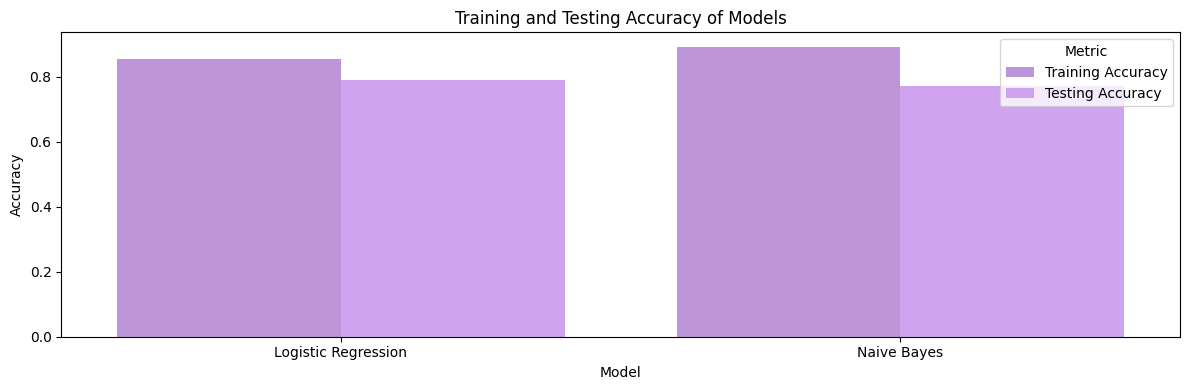

In [24]:
df_melted = df_performance.melt(id_vars='Model', value_vars=['Training Accuracy', 'Testing Accuracy'],
                                var_name='Metric', value_name='Score')

# Plot training and testing accuracy
plt.figure(figsize=(12, 4))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette=[colors[8], colors[9]])
plt.title('Training and Testing Accuracy of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()